# AXPY Scaling

**(with the number of threads)**

Unfortunately, we can't change the number of Julia threads dynamically.

**Poor-man's workaround:**
* Start Julia with 128 threads (= # CPU-cores) and 
* dynamically choose how many of them to use in `measure_perf`.

**Now: Make sure to use the Julia kernel with 128 threads for this notebook !!!**

In [1]:
using Base.Threads: @threads, nthreads
using ThreadPinning
using BenchmarkTools
using Random

How to implement the strategy above? → e.g. `Iterators.partition` or [ChunkSplitters.jl](https://github.com/m3g/ChunkSplitters.jl)

In [2]:
using ChunkSplitters

In [3]:
chunks(1:12, 2) |> collect

2-element Vector{Tuple{StepRange{Int64, Int64}, Int64}}:
 (1:1:6, 1)
 (7:1:12, 2)

In [4]:
chunks(1:12, 3) |> collect

3-element Vector{Tuple{StepRange{Int64, Int64}, Int64}}:
 (1:1:4, 1)
 (5:1:8, 2)
 (9:1:12, 3)

In [5]:
function example(data; nthreads=nthreads())
    @threads :static for (idcs, tid) in chunks(data, nthreads)
        println("Doing work on thread $tid")
        for i in idcs
            # do work...
        end
    end
end

example (generic function with 1 method)

In [6]:
example(rand(100); nthreads=2)

Doing work on thread 1
Doing work on thread 2


In [7]:
example(rand(100); nthreads=10)

Doing work on thread 1
Doing work on thread 3
Doing work on thread 6
Doing work on thread 4
Doing work on thread 5
Doing work on thread 2
Doing work on thread 10
Doing work on thread 8
Doing work on thread 7
Doing work on thread 9


### AXPY with `nthreads` option

In [8]:
function axpy_static_chunks!(y, a, x; chunks)
    @threads :static for (idcs, tid) in chunks
        @simd for i in idcs
            @inbounds y[i] = a * x[i] + y[i]
        end
    end
    return nothing
end

function generate_input_data_chunks(; N, dtype, parallel=false, static=false, chunks, kwargs...)
    a = dtype(3.141)
    x = Vector{dtype}(undef, N)
    y = Vector{dtype}(undef, N)
    if !parallel
        rand!(x)
        rand!(y)
    else
        if !static
            @threads for (idcs, tid) in chunks
                @inbounds for i in idcs
                    x[i] = rand()
                    y[i] = rand()
                end
            end
        else
            @threads :static for (idcs, tid) in chunks
                @inbounds for i in idcs
                    x[i] = rand()
                    y[i] = rand()
                end
            end
        end
    end
    return a,x,y
end

function measure_perf_chunks(; N=2^27, dtype=Float64, verbose=true, nthreads=Threads.nthreads(), kwargs...)
    # input data
    cs = chunks(1:N, nthreads)
    a, x, y = generate_input_data_chunks(; N, dtype, chunks=cs, kwargs...)

    # time measurement
    t = @belapsed axpy_static_chunks!($y, $a, $x; chunks=$cs) evals = 2 samples = 10

    # compute memory bandwidth and flops
    bytes = 3 * sizeof(dtype) * N
    flops = 2 * N
    mem_rate = bytes * 1e-9 / t
    flop_rate = flops * 1e-9 / t

    if verbose
        println("Dtype: $dtype")
        println("\tMemory Bandwidth (GB/s): ", round(mem_rate; digits=2))
        println("\tCompute (GFLOP/s): ", round(flop_rate; digits=2))
    end
    return mem_rate, flop_rate
end

measure_perf_chunks (generic function with 1 method)

In [9]:
pinthreads(:numa)
measure_perf_chunks(; nthreads=1, parallel=true, static=true);
measure_perf_chunks(; nthreads=8, parallel=true, static=true);

Dtype: Float64
	Memory Bandwidth (GB/s): 37.43
	Compute (GFLOP/s): 3.12
Dtype: Float64
	Memory Bandwidth (GB/s): 304.28
	Compute (GFLOP/s): 25.36


### Scaling analysis: tabular

In [10]:
using PrettyTables

function axpy_scaling_table(; nthreads=1:Threads.nthreads(), kwargs...)
    for nt in nthreads
        membw_results = Matrix{Float64}(undef, 3, 2)
        for (i, pin) in enumerate((:cores, :sockets, :numa))
            for (j, parallel) in enumerate((false, true))
                pinthreads(pin)
                membw, flops = measure_perf_chunks(; nthreads=nt, parallel=parallel, static=true, verbose=false, kwargs...)
                membw_results[i, j] = round(membw; digits=2)
            end
        end
        
        # (pretty) printing
        println()
        pretty_table(membw_results;
            header=[":serial", ":parallel"],
            row_names=[":cores", ":sockets", ":numa"],
            row_name_column_title="# Threads = $nt",
            title="Memory Bandwidth (GB/s)")
    end
end

axpy_scaling_table (generic function with 1 method)

In [11]:
 # should take around 3 min
@time axpy_scaling_table(; nthreads=[1, 8, 64, 128], N=2^30)


Memory Bandwidth (GB/s)
┌───────────────┬─────────┬───────────┐
│ # Threads = 1 │ :serial │ :parallel │
├───────────────┼─────────┼───────────┤
│        :cores │   37.12 │     37.81 │
│      :sockets │   39.32 │     37.78 │
│         :numa │   37.88 │      37.8 │
└───────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌───────────────┬─────────┬───────────┐
│ # Threads = 8 │ :serial │ :parallel │
├───────────────┼─────────┼───────────┤
│        :cores │    38.1 │     38.22 │
│      :sockets │   38.51 │     80.46 │
│         :numa │   39.01 │    297.53 │
└───────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌────────────────┬─────────┬───────────┐
│ # Threads = 64 │ :serial │ :parallel │
├────────────────┼─────────┼───────────┤
│         :cores │    37.7 │    157.88 │
│       :sockets │    35.3 │    158.01 │
│          :numa │   35.63 │    304.55 │
└────────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌─────────────────┬─────────┬───────────┐
│ # Threads

### Scaling analysis: plot

In [12]:
using Plots

function axpy_scaling_plot(; nthreads=1:Threads.nthreads(), kwargs...)
    membws = Dict{Symbol, Vector{Float64}}()
    membws[:cores] = zeros(length(nthreads))
    membws[:sockets] = zeros(length(nthreads))
    membws[:numa] = zeros(length(nthreads))
    
    for (t, nt) in enumerate(nthreads)
        for (p, pin) in enumerate((:cores, :sockets, :numa))
            pinthreads(pin)
            membw, flops = measure_perf_chunks(; nthreads=nt, parallel=true, static=true, verbose=false, kwargs...)
            membws[pin][t] = round(membw; digits=2)
        end
    end
    
    props = (marker=:circle, ms=5, lw=1.5)
    p = plot(nthreads, membws[:numa]; label=":numa", props...,
        frame=:box,
        xlabel="number of threads",
        ylabel="memory bandwidth [GB/s]",
        size=(700,450),
        xlim=(0,129),
        xticks=[1,32,64,128],
        tickfontsize=12,
        guidefontsize=13,
        legendfontsize=12,
        linewidth=1.5)
    plot!(p, nthreads, membws[:sockets]; props..., label=":sockets")
    plot!(p, nthreads, membws[:cores]; props..., label=":cores")

    if maximum(nthreads) > 64
        vline!(p, [64]; ls=:dash, color=:grey, lw=1.5, label=nothing)
    end
    
    return p
end

axpy_scaling_plot (generic function with 1 method)

298.001785 seconds (1.74 M allocations: 816.157 GiB, 27.27% gc time, 0.37% compilation time)


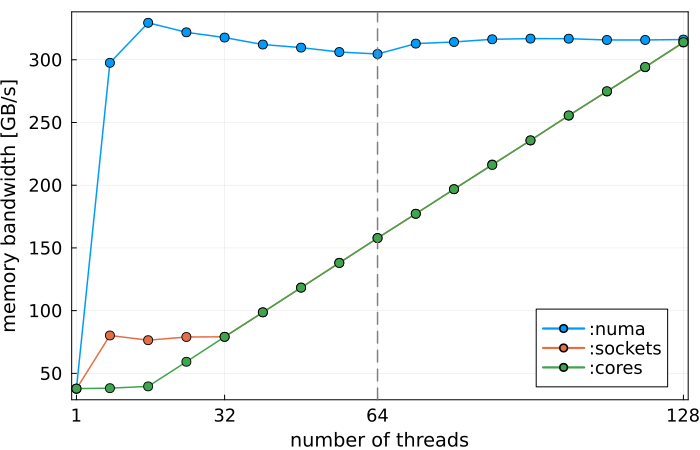

In [14]:
# should take ≈ 5 min
@time axpy_scaling_plot(; nthreads=[1; 8:8:128], N=2^30)